## [*pyKNEEr*](https://github.com/sbonaretti/pyKNEEr) - Example #1 
# [Hands-on transparent QMSKI](https://github.com/sbonaretti/2019_QMSKI_Transparent_Research_WS)
### Lake Louise, Canada - February 25, 2019
#### Serena Bonaretti

--- 

Simplified version of *pyKNEEr* workflow

### [Segmentation](#segmentation)
- Output visualization

### [Morphology](#morphology)   
- Cartilage thickness 
- Cartilage volume

### [Relaxometry](#relaxometry)
- Fitting maps

---

#### Imports

In [1]:
from pykneer import pykneer_io as io
from pykneer import preprocessing_for_nb as prep
from pykneer import segmentation_for_nb as segm
from pykneer import morphology_for_nb as morph
from pykneer import relaxometry_for_nb as rel
import itk
import itkwidgets
from itkwidgets import view

---

# [Segmentation](https://sbonaretti.github.io/pyKNEEr/segmentation.html) <a name="segmentation"></a>

Segmentation is performed using an atlas-based algorithm. Given a segmented image (reference image), we use registration to segment each image (moving image) of the dataset. 

The segmentation consists of two parts:  
- Segment bone (used to initialize femoral cartilage segmentation)
- Segment cartilage

Each part is composed by 3 steps:  
- Step 1: *Register image to reference*. The moving image is registered to the reference image
- Step 2: *Invert transformation*. Transformations are inverted
- Step 3: *Warp reference mask to moving image*. Inverted transformations are applied to the mask of the reference image to obtain the mask of the moving image  

Registration, inversion, and warping are executed by calling *elastix*

*Note: Segmentation here skipped in this notebook for time constraints*

## Image information

Inputs:   
- `input_file_name` contains the list of the images to be segmented  
- `modality` can be "newsubject", "longitudinal", or "multimodal"

In [3]:
input_file_name = "./image_list_newsubject.txt"
modality        = "newsubject" 

#### Read image data
- `imageData` is a dictionary (or struct), where each cell corresponds to an image. For each image, information such as paths and file names are stored  

In [4]:
image_data = io.load_image_data_segmentation(modality, input_file_name)

-> image information loaded


## Visualize segmentations
Visual check of the results. For each image (row), segmentation at medial, central, and lateral compartments

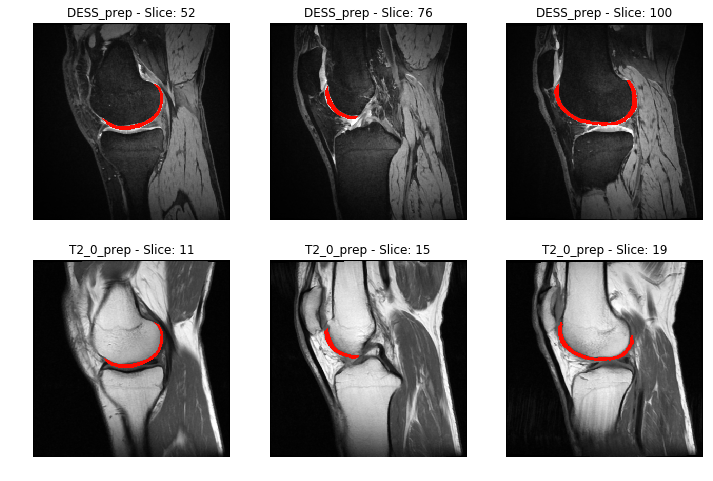

In [5]:
segm.show_segmented_images(image_data)

---

# [Morphology](https://sbonaretti.github.io/pyKNEEr/morphology.html) <a name="morphology"></a>

Morphology quantifications of femoral cartilage are:  

- *Thickness*, computed in two steps:  
  - Separation of subcondral surface and articular surface of the cartilage
  - Calculation of the distance between the two surfaces using a nearest neighbor method

- *Volume*, calculated as the volume of the cartilage mask multiplied by the image resolution

## Image information

Inputs:   
- `input_file_name` contains the list of femoral cartilage masks
- `thickness_algo` is the algorithm used to calculate cartilage thickness
- `output_file_name_thickness` contains the table with average and standard deviation of thickness
- `output_file_name_volume` contains the table with average volumes

In [6]:
input_file_name            = "./image_list_morphology.txt"
thickness_algo             = 1 # 1 for nearest neighbor on bone-cartilage surface 
n_of_cores                 = 1
output_file_name_thickness = "thickness.csv"
output_file_name_volume    = "volume.csv"

#### Read image data
- `image_data` is a dictionary (or struct), where each cell corresponds to an image. For each image, information such as paths and file names are stored  

In [7]:
image_data = io.load_image_data_morphology(input_file_name)

-> image information loaded


## Cartilage Thickness

### Separating subcondral surface and articular surface of cartilage

To calculate cartilage thickness, first the cartilage surface is extracted from the binary mask. Then subcondral surface and articular surface are divided in two separate point clouds

In [8]:
morph.separate_cartilage_surfaces(image_data, n_of_cores)

#### Visual check 
Subcondral bone surface (yellow) and articular surface (blue) are visualized as flattened point clouds. The flattening is with respect to a cylinder interpolated into the cartilage surface [2]

DESS_prep_fc.mha
T2_0_prep_fc.mha


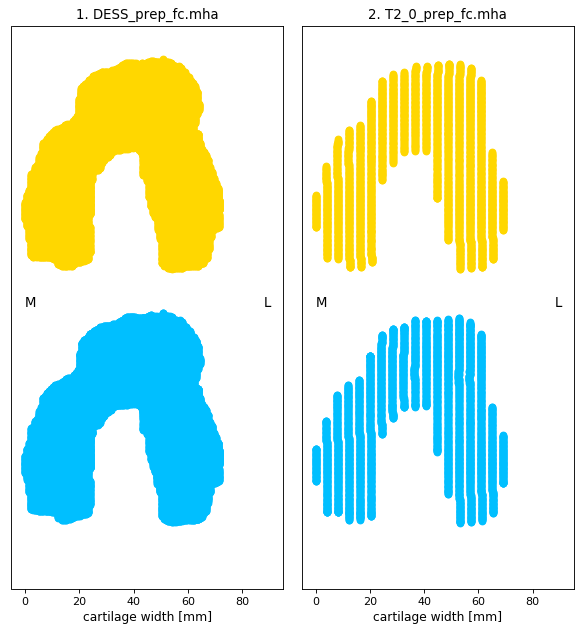

In [9]:
morph.show_cartilage_surfaces(image_data)

### Calculating cartilage thickness

Assign the chosen algorithm 

In [10]:
morph.algorithm(image_data, thickness_algo)

Calculate thickness

In [11]:
morph.calculate_thickness(image_data, n_of_cores)

DESS_prep_fc.mha
T2_0_prep_fc.mha
-> Thickness computed
-> The total time was 14.21 seconds (about 0 min)


### Visualizing cartilage thickness

#### MAP: Thickness is represented as a colormap on the flattened cartilage

DESS_prep_fc.mha
T2_0_prep_fc.mha


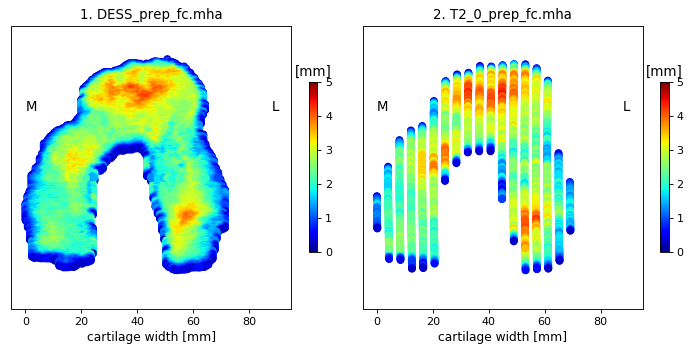

In [12]:
morph.show_thickness_maps(image_data)

#### GRAPH: Dots represent the average value of cartilage thickness per image; bars represents the standard deviation

<Figure size 1296x576 with 0 Axes>

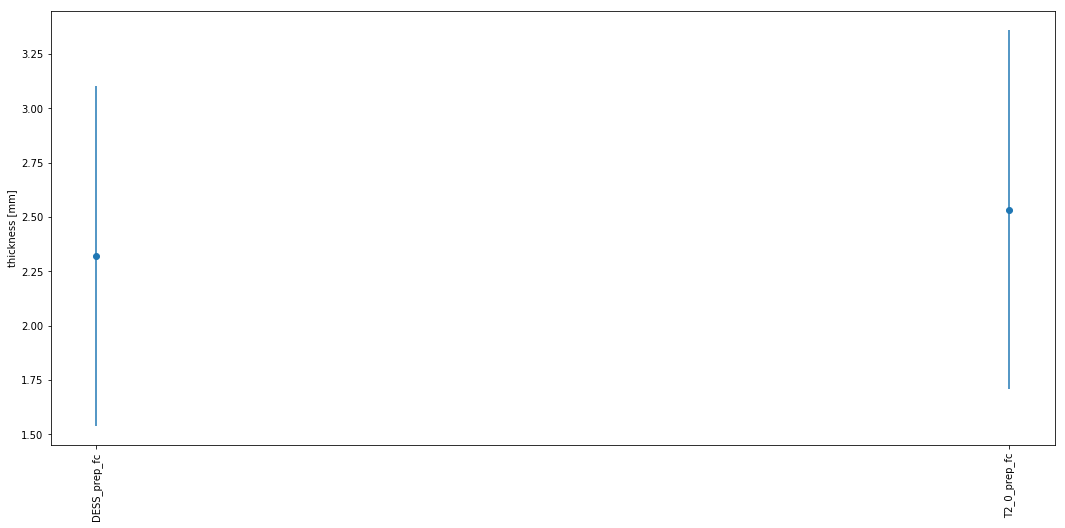

In [13]:
morph.show_thickness_graph(image_data)

#### TABLE: Average and standard deviation of cartilage thickness per image
The table is saved as a .csv file for subsequent analyisis

In [14]:
table = morph.show_thickness_table(image_data, output_file_name_thickness)
display(table)

Table saved as: thickness.csv


,Subjects,averageThickness,std.dev
1,DESS_prep_fc_thickness_1,2.32,0.78
2,T2_0_prep_fc_thickness_1,2.53,0.83


## Cartilage Volume

Calculate cartilage volume

In [15]:
morph.calculate_volume(image_data)

DESS_prep_fc.mha
T2_0_prep_fc.mha
-> Volume computed


### Visualizing cartilage volume

#### GRAPH: Dots represent cartilage volume per image

<Figure size 1296x576 with 0 Axes>

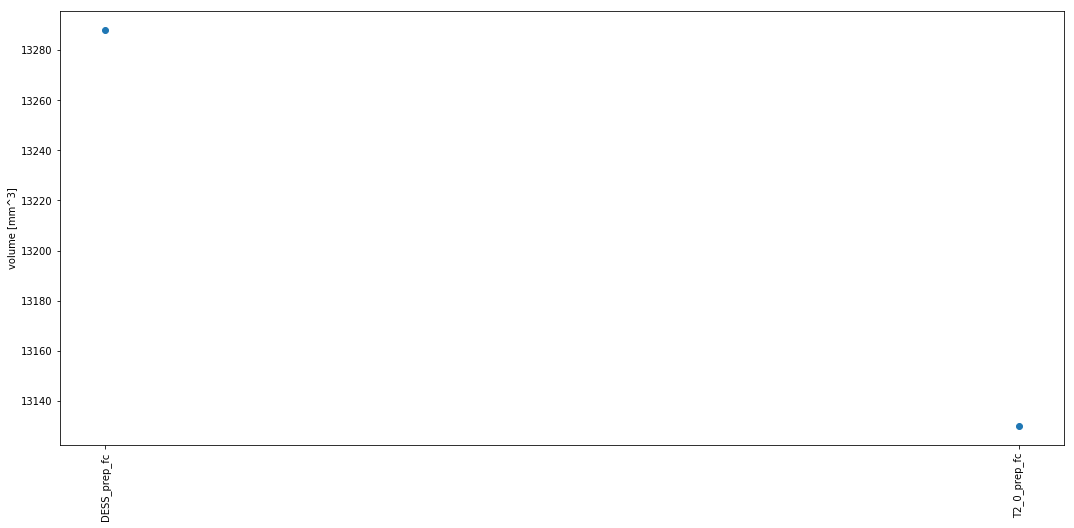

In [16]:
morph.show_volume_graph(image_data)

#### TABLE: Cartilage volume per image
The table is saved as a .csv file for subsequent analyisis

In [17]:
table = morph.show_volume_table(image_data, output_file_name_volume)
display(table)

Table saved as: volume.csv


,Subjects,Volume
1,DESS_prep_fc,13288
2,T2_0_prep_fc,13130


---

# [Relaxometry - Exponential and linear fitting](https://sbonaretti.github.io/pyKNEEr/relaxometry.html) <a name="relaxometry"></a>

- *Exponential* fitting is computationally expensive but more accurate
- *Linear fitting* is faster as data are transformed to their log and then linearly interpolated. However, linear fitting is less accurate because the nonlinear logaritmic transform provides larger weight to outliers  

The fitting is computed:  
- *directly* on the acquired images or after *rigid registration* of the following echo to the first echo  
- voxel-wise, i.e. for each voxel the Echo Times (dicom tag: (0018,0081)) are the x-variable and the voxel intensities in each acquisition are the y-variable
- only in the mask volume to have short computation time

## Image information

Inputs:   
- `input_file_name` contains the list of the images used to calculate the relaxation maps
- `method` is `0` if fitting is linear, `1` if fitting is exponential
- `registration_flag` is `0` for no registration, `1` for rigid registration
- `output_file_name` contains average and standard deviation of the fitting maps 

In [18]:
input_file_name   = "./image_list_relaxometry_fitting.txt"
method_flag       = 0 # 0 = linear, 1 = exponential
registration_flag = 0 # no registration for time constraints
output_file_name  = "fit.csv"

#### Read image data
- `image_data` is a dictionary (or struct), where each cell corresponds to an image. For each image, information such as paths and file names are stored  

In [19]:
image_data = io.load_image_data_fitting(input_file_name, method_flag, registration_flag)

-> information loaded for 1 subjects
-> for each subjects there are 7 acquisitions


## Calculate fitting maps

In [20]:
rel.calculate_fitting_maps(image_data, n_of_cores)

-> using linear fitting 
T2_0_orig.mha
-> Fitting maps calculated
-> The total time was 0.42 seconds (about 0 min)


## Visualize fitting maps

#### 2D MAP: For each image, fitting maps at medial and lateral compartments and flattened map
The flattened map is an average of neighnoring voxels projected on the bone surface side of the femoral cartilage

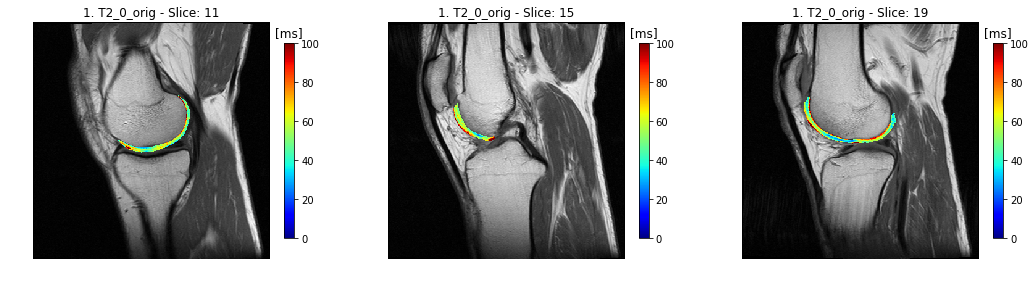

In [21]:
rel.show_fitting_maps(image_data)

#### 3D MAP: Interactive rendering of fitting maps

In [22]:
# ID of the map to visualize (first number in the title of the visualization above)
image_ID = 0

# read image
file_name = image_data[image_ID]["relaxometryFolder"] + image_data[image_ID]["mapFileName"]
image = itk.imread(file_name)

# view
viewer = view(image, gradient_opacity=0.0, ui_collapsed=False, shadow=False)
viewer

Viewer(gradient_opacity=0.01, rendered_image=<itkImagePython.itkImageSS3; proxy of <Swig Object of type 'itkIm…

#### GRAPH: Dots represent the average value of fitting maps per image; bars represents the standard deviation

<Figure size 1296x576 with 0 Axes>

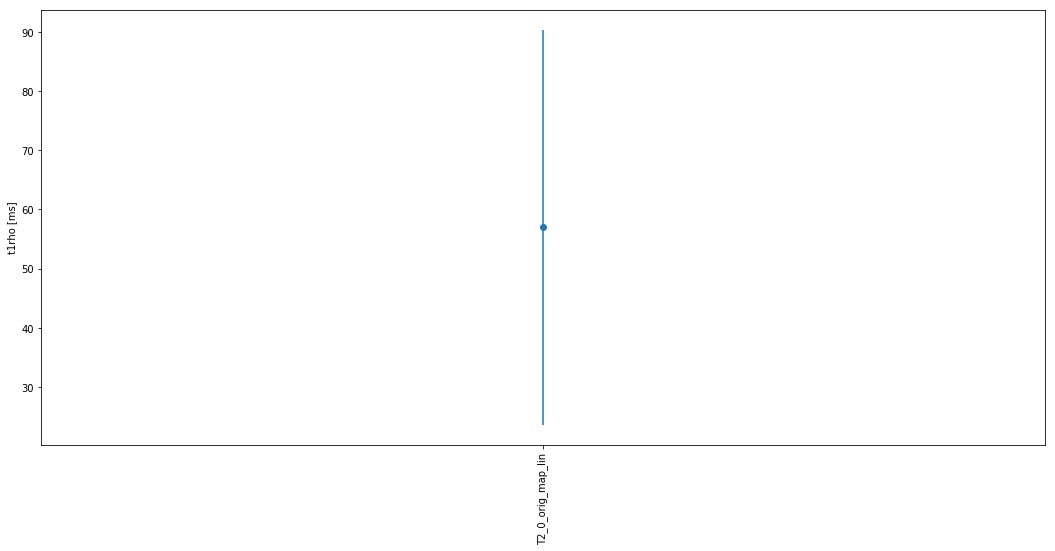

In [23]:
rel.show_fitting_graph(image_data)

#### TABLE: Average and standard deviation of fitting maps per image
The table is saved as a .csv file for subsequent analyisis

In [24]:
rel.show_fitting_table(image_data, output_file_name)

Table saved as: exp_fit.csv


,subjects,average,std.dev
1,T2_0_orig_map_lin.mha,56.98,33.4


---

### Dependencies

In [25]:
%load_ext watermark
print ("elastix 4.8.0\n")
%watermark -v -m -p SimpleITK,numpy,matplotlib,multiprocessing

elastix 4.8.0

CPython 3.7.1
IPython 6.5.0

SimpleITK unknown
numpy 1.15.1
matplotlib 2.2.3
multiprocessing unknown

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
